### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2023 ###

### Final Course Project: Due 5/5/23

# Autonomous Vehicle Control using PID and MPC Controllers  #

#### NEVINDU BATAGODA (batagoda@wis.edu)
#### ISHAAN MAHAJAN (imahajan@wisc.edu) 


*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
    1. [Bicycle Model](#2.1-The-2D-Bicycle-Model)
    1. [PID Control](#2.2-Proportional-Derivative-Integral-(PID)-Controller)
    1. [MPC](#2.3-Model-Predictive-Contro-(MPC))
1. [Solution](#3.-Solution)
    1. [PID Implementation](#3.1-PID-Controller-Implementation)
    1. [MPC Implementation](#3.2-MPC-Controller-Implementation)
1. [Results and Discussion](#4.-Results-and-discussion)
  1. [PID Controller Evaluation](#4.1-PID-Controller-Evaluation)
  1. [MPC Controller Evaluation](#4.2-MPC-Controller-Evaluation)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##
This project is inspired by our work as members of Wisconsin Autonomous student organization. We are part of a university team competing in the AutoDrive Challenge II competition organized by SAE International and General Motors. The goal of this competition is to build a self-driving car capable of navigating urban environments.

As part of the control stack of the self-driving car, there are three planners: 1) The High-Level planner which creates a set of target waypoints to follow, 2) The Mid Level planner which generates a smooth trajectory from the waypoints and 3) A Low-Level planner, which uses a feedback control algorithm to generate a target velocity and heading which is then passed into the vehicle as a throttle and a steering input.

In this project, we plan to address the problem of the Low-Level Planner of the Wisconsin Autonomous control stack. Our objective is to find a suitable controller that will be able to handle various urban driving scenarios such as obstacle avoidance. To that end, we implement and design two controllers,

1. [Proportional Integral Derivative (PID) Controller](https://en.wikipedia.org/wiki/PID_controller) -  A feedback control mechanism that regulates a process by adjusting its inputs based on error signals
2. [Model Predictive Controller (MPC) ](https://en.wikipedia.org/wiki/Model_predictive_control) - An advanced feedback control that uses a mathematical model to predict future behavior and optimize control action

In order to evaluate the performance of our controllers we test them on several different trajectories and obstacle avoidance scenarios. The data for the trajectories are from the [Autonomy Research Test Bed (ART)](https://arxiv.org/abs/2211.04886) of UW-Madison [Simulation-Based Engineering Laboratory](https://sbel.wisc.edu/).

In the [2nd Section](#1.-Mathematical-model) we give an overview of the mathematics behind the vehicle dynamics model we use, the PID controller and the MPC controller.  In the [3rd Section](#3.-Solution) we provide the Julia-based implementation of our controllers, and in the [4th Section](#4.-Results-and-discussion) we conduct an evaluation of our results.






## 2. Mathematical model ##

### 2.1 The 2D Bicycle Model ###

The kinematic bicycle model is a simplified representation used for modeling the dynamics of vehicles and is widely used in control systems. It is called a "bicycle model" because it reduces a four-wheeled vehicle to a two-wheeled representation, focusing on the vehicle's center of mass and treating the front and rear wheels as if they were a single point each. The model assumes that the vehicle moves in a flat plane and that there is no tire slip. It also ignores forces like aerodynamics and friction for simplicity. Even though it is a simplified model, the bicycle model works well for our purposes. The bicycle model has 4-Degrees of Freedom and is described as follows.

Let our state variable be $\textbf{x}_t = [x\, y\, \psi \, v]$, which contains the current position, heading angle $(\psi)$ and the velocity $v$.

Let our control inputs be $\textbf{u}_t = [a \; \delta]$. which contains the acceleration input($a$) and the steering angle input ($u$/

Hence for a give input state $\textbf{x}_t$ and a give control input $\textbf{u}_t$ at time $t$, the bicycle model $f(\textbf{x}_t,\textbf{u}_t)$, can be used to determine the next state $\textbf{x}_{t+1}$,

$$\textbf{x}_{t+1} = \textbf{x}_{t} + f(\textbf{x}_t,\textbf{u}_t) \Delta t \\
\text{where, } \quad  f(\textbf{x}_t,\textbf{u}_t) =  \begin{bmatrix}
v\cos(\psi) \\
v\sin(\psi) \\
\frac{v\tan(\delta)}{L} \\
a 
\end{bmatrix}
$$

Here $L$ is the length of the vehicle, or rather the distance between the front and rear wheels of the bicycle model.

![bicyle-model][bicycle]




#### 2.2 Proportional Derivative Integral (PID) Controller ###

PID control is a widely used feedback control algorithm in various engineering applications, such as process control, robotics, and automation systems. The primary objective of a PID controller is to minimize the error between a desired setpoint and a measured process variable, thereby regulating the system output to achieve the desired performance. PID control consists of Proportional, Derivative, and Integral components. The mathematical formulation is as follows,


$$ \textbf{u(t)} =  K_p \textbf{e(t)} + K_i \int_{0}^{t} \textbf{e($\tau$)} d\tau + K_d \frac{d\textbf{e(t)}}{dt}$$

Where,  $K_p,K_i,K_d \geq 0 $ are the PID gain coefficients and are usually tuned manually. They each control the influence of the proportional, integral, and derivative terms respectively.

Here, $\textbf{e(t)}$ is the error between the target state $r(t)$ and the measured process state, $y(t)$, 
$$e(t) = r(t) - y(t) $$

The target states are ususally produced by some sort of a motion planning algorithm.

The output, $\textbf{u(t)}$ of the PID controller, is the neccessary control inputs required to acheive the target state.

A diagram of the PID controller is shown below 

<img src="https://plcynergy.com/wp-content/uploads/2021/01/PID-controller.jpg"  width="600" height="600">

[bicycle]: https://www.researchgate.net/publication/318810853/figure/fig1/AS:526533921120256@1502546877982/Kinematic-bicycle-model-of-the-vehicle.png


#### 2.3 Model Predictive Control (MPC) ###

Model Predictive Control (MPC) [[paper]](https://arxiv.org/abs/2304.09156) is an advanced control strategy used in control system engineering. The main idea behind MPC is to optimize the control actions over a finite prediction horizon using a mathematical model of the system, taking into account constraints on inputs, outputs, and states. MPC aims to minimize a cost function, which represents the desired performance objectives, such as meeting a reference target or minimizing energy consumption.

At each time steps, MPC finds the next $T$ set of control inputs ($\textbf{u}_{1:T}$) needed to meet the next $T$ target states($\textbf{x}_t^{ref}$) of the trajectory. It does this by solving the following optimization problem, 


$$ \min\limits_{\textbf{x}_{1:T},\textbf{u}_{1:T}} \quad J(\textbf{x}_{1:T},\textbf{u}_{1:T}) \\
\text{subject to, } \textbf{x}_{t+1} =   \textbf{x}_{t} + f(\textbf{x}_t,\textbf{u}_t) \Delta t \quad \forall t \in [T-1]\\
\textbf{u}_t \in \mathcal{U}_t \quad \forall t \in [T] \\
\textbf{x}_t \in \mathcal{X}_t \quad \forall t \in [T] \\
\textbf{x}_1 = \textbf{x}_\text{init}
$$
 
Where, $f(\textbf{x}_t,\textbf{u}_t)$ is the bicycle dynamics model defined above, $\textbf{x}_t$ is the state at time $t$, $\textbf{u}_t$ is the control inputs at time $t$, $\mathcal{U}_t$ are the set of constraints for the control inputs and $\mathcal{X}_t$ is the set of constraints for the state variables.

For example, one can constraint the control inputs to have a certain minimum and maximum acceleration and steering angle. And one can also set constraints to the state vectors to avoid certain obstacles.

And finally, the objective function of the optimization problem is defined as follows,

$$  J(x_{1:T},u_{1:T}) = \textbf{e}_t^T Q \textbf{e}_t + \textbf{u}_t^T R \textbf{u}_t$$

Where, in the first term,  $\textbf{e}_t = \textbf{x}_t - \textbf{x}_t^{ref}$ is the measurement error vector, and $Q$ is a diagonal matrix that contains the penalties for each term in the state vector. The second term is the cost for applying control inputs, $R$ is a diagonal matrix that has penalties for each control input.

The first term penalizes errors in measurements and keeps the car in the reference trajectory and the second term penalizes aggressive control inputs, encouraging trajectories that have low acceleration and low steering input.

It is clear, that the objective function has a quadratic nature and thus solving the optimization involves solving a Quadratic Program which is a convex optimization problem.


The Overall MPC algorithm is as follows,

**Input**: Predict Horizon $T$, Dynamics model $f$, Objective $J$, Initial State $\hat{\textbf{u}}_{1:T}$

**Algorithm**:

1. $\textbf{u}_{1:T} \leftarrow \hat{\textbf{u}}_{1:T}$

1. At each time step $t$,
    1. $\textbf{x}_{\text{init}} \leftarrow \text{GetCurrentState()}$
    1. $\textbf{u}_{1:T} \leftarrow \text{SolveOptimizationProblem($J,f,x_\text{init}T,\textbf{u}_{1:T}$)}$
    1. $\textbf{u}_{t+1} \leftarrow \text{First(}\textbf{u}_{1:T}\text{)}$
    1. $\text{ApplyInput($\textbf{u}_{t+1}$)}$


**Note**: As shown in step C, After solving the optimization problem for $T$ steps, MPC only uses only the first optimal control input from $\textbf{u}_{1:T}^*$ to apply to the vehicle.

## 3. Solution ##



### 3.1 PID Controller Implementation

In [1]:
using DelimitedFiles, LinearAlgebra, Plots, StatsPlots, JuMP, Ipopt


In [3]:
function search_min_distance(x::Float64, y::Float64, x_ref::Vector{Float64}, y_ref::Vector{Float64})
    # find minimum distance between current car's position and reference and give the index of that point in the reference trajectory
    dis = zeros(length(x_ref))
    min_dis = 100000
    index = -1
    for i in 1:length(dis)-1
        dis[i] = (x - x_ref[i])^2 + (y - y_ref[i])^2
        if dis[i] < min_dis
            min_dis = dis[i]
            index = i
        end
    end
    return min_dis, index
end

search_min_distance (generic function with 1 method)

In [4]:
function dynamics(x::Float64, y::Float64, v::Float64, theta::Float64, a::Float64, theta_dot::Float64)
    
    model = Model((Ipopt.Optimizer))
    set_silent(model)
    
    # Define variables
    @variable(model, x_next)
    @variable(model, y_next)
    @variable(model, v_next)
    @variable(model, theta_next)
    dt = 0.1 
    
    # Define constraints
    @NLconstraint(model, x_next == x + v * cos(theta) * dt)
    @NLconstraint(model, y_next == y + v * sin(theta) * dt)
    @NLconstraint(model, v_next == v + a * dt)
    @NLconstraint(model, theta_next == theta + (v*tan(theta_dot)) * dt)

    # Define objective function
    @NLobjective(model, Min, 0)
    
    # Solve problem
    optimize!(model)

    # Extract solution
    x_next = value(x_next)
    y_next = value(y_next)
    v_next = value(v_next)
    theta_next = value(theta_next)

    return x_next, y_next, v_next, theta_next
end

dynamics (generic function with 1 method)

In [5]:
function direction(theta_ref::Float64, theta::Float64, theta_dot::Float64)
    model = Model((Ipopt.Optimizer))
    set_silent(model)
    @variable(model, theta_dot_raw)
    @constraint(model, theta_dot_raw == theta_dot)
    @NLconstraint(model, theta_dot_raw - theta_dot * (theta - theta_ref) <= 0)
    @NLconstraint(model, theta_dot_raw + theta_dot * (theta - theta_ref) >= 0)
    @objective(model, Min, 0)
    optimize!(model)
    return value(theta_dot_raw)
    

end

direction (generic function with 1 method)

In [171]:
data = readdlm("input_trajectory.csv", ',', Float64)
x_ref = data[:,1]
y_ref = data[:,2]
theta_ref = zeros(length(x_ref))
for i in 1:length(x_ref)-1
    theta_ref[i] = pi + atan(y_ref[i+1]-y_ref[i], x_ref[i+1]-x_ref[i])
    
end


t_start = time()
time_span = 30
dt = 0.1
Kp = 4.0
Kd = 2.0
v = .4
accel = 0.00001
x_current = x_ref[1]
y_current = y_ref[1]
theta_current = 0.01
theta_dot_current = 0.0
min_dis_pre = 0.0
traj_x_rect = [x_current]
traj_y_rect = [y_current]
traj_theta = [theta_current]

for i in 1:1300
    
    min_dis, index = search_min_distance(x_current, y_current, x_ref, y_ref)
    
    theta_dot_raw = Kp * min_dis
    theta_dot_current = direction(theta_ref[index], theta_current, theta_dot_raw)
    push!(traj_theta, (theta_current - theta_ref[index]))
    theta_dot_current = theta_dot_current * Kd * abs(min_dis - min_dis_pre) # Using K_p & K_d together

    min_dis_pre = min_dis
    
    x_current, y_current, v, theta_current = dynamics(x_current, y_current, v, theta_current, accel, theta_dot_current)


    push!(traj_x_rect, x_current)
    push!(traj_y_rect, y_current)

end



In [7]:
data = readdlm("Circle_Traj_CW.csv", ',', Float64)
x_ref_circle = data[:,1]
y_ref_circle = data[:,2]
theta_ref = zeros(length(x_ref_circle))
for i in 1:length(x_ref_circle)-1
    theta_ref[i] = pi + atan(y_ref_circle[i+1]-y_ref_circle[i], x_ref_circle[i+1]-x_ref_circle[i])
    
end


t_start = time()
time_span = 30
dt = 0.1
Kp = 4.0
Kd = 2.0
v = .4
accel = 0.00001
x_current = x_ref_circle[1]
y_current = x_ref_circle[1]
theta_current = 0.01
theta_dot_current = 0.0
min_dis_pre = 0.0
traj_x_circle = [x_current]
traj_y_circle = [y_current]
traj_theta = [theta_current]

for i in 1:1300
    
    min_dis, index = search_min_distance(x_current, y_current, x_ref_circle, y_ref_circle)
    
    theta_dot_raw = Kp * min_dis
    theta_dot_current = direction(theta_ref[index], theta_current, theta_dot_raw)
    push!(traj_theta, (theta_current - theta_ref[index]))
    theta_dot_current = theta_dot_current * Kd * abs(min_dis - min_dis_pre) # Using K_p & K_d together

    min_dis_pre = min_dis
    
    x_current, y_current, v, theta_current = dynamics(x_current, y_current, v, theta_current, accel, theta_dot_current)


    push!(traj_x_circle, x_current)
    push!(traj_y_circle, y_current)

end



In [54]:
function sine_reference_trajectory_gen(t)
    x_ref = t
    y_ref = sin(t)
    psi_ref = atan(cos(t))
    v_ref = 1.0
    return [x_ref, y_ref, psi_ref, v_ref]
end

sine_reference_trajectory_gen (generic function with 1 method)

In [55]:
# data = readdlm("Sin_Traj.csv", ',', Float64)
# x_ref_sin = data[:,1]
# x_ref_sin = data[:,2]
# theta_ref = zeros(length(x_ref_sin))
# for i in 1:length(x_ref_sin)-1
#     theta_ref[i] = pi + atan(y_ref_sin[i+1]-y_ref_sin[i], x_ref_sin[i+1]-x_ref_sin[i])
    
# end
len = 200
t = range(0,step=0.1,length=len)
ref_traj = Matrix{Float64}(undef, len,4)
for (i,t) in enumerate(t)
    ref_traj[i,:] = sine_reference_trajectory_gen(t)
end
x_ref_sin = ref_traj[:,1][1:100]
y_ref_sin = ref_traj[:,2][1:100]
theta_ref = ref_traj[:,3][1:100]
ref_v = ref_traj[:,4][1:100]


t_start = time()
time_span = 30
dt = 0.1
Kp = 4.0
Kd = 2.0
v = .4
accel = 0.00001
x_current = x_ref[1]
y_current = y_ref[1]
theta_current = 0.01
theta_dot_current = 0.0
min_dis_pre = 0.0
traj_x_sin = [x_current]
traj_y_sin = [y_current]
traj_theta = [theta_current]

for i in 1:1300
    
    min_dis, index = search_min_distance(x_current, y_current, x_ref_sin, y_ref_sin)
    
    theta_dot_raw = Kp * min_dis
    theta_dot_current = direction(theta_ref[index], theta_current, theta_dot_raw)
    push!(traj_theta, (theta_current - theta_ref[index]))
    theta_dot_current = theta_dot_current * Kd * abs(min_dis - min_dis_pre) # Using K_p & K_d together

    min_dis_pre = min_dis
    
    x_current, y_current, v, theta_current = dynamics(x_current, y_current, v, theta_current, accel, theta_dot_current)


    push!(traj_x_sin, x_current)
    push!(traj_y_sin, y_current)

end



### 3.2 MPC Controller Implementation ###

In [12]:
using JuMP
using Gurobi, Ipopt
using Plots
using DataFrames
using CSV
using DelimitedFiles

In [14]:
function bicycle_model(state, input, dt, L)
    x, y, psi, v = state
    delta, a = input

    x_new = x + v * cos(psi) * dt
    y_new = y + v * sin(psi) * dt
    psi_new = psi + (v * tan(delta) / L) * dt
    v_new = v + a * dt

    return [x_new, y_new, psi_new, v_new]
end


bicycle_model (generic function with 1 method)

In [15]:
function mpc_solver(state, T, dt, L, Q, R, step, u_prev, reference_trajectory, obstacles)
    
#     if step+T > size(reference_trajectory)[1]
#         T = size(reference_trajectory)[1] - step + 1
#         println("HELLO ", step, " ", T)
#     end
    
    model = Model(Ipopt.Optimizer)
    set_silent(model)
    @variable(model, x[1:T+1])
    @variable(model, y[1:T+1])
    @variable(model, psi[1:T+1])
    @variable(model, v[1:T+1])
    @variable(model, delta[1:T])
    @variable(model, a[1:T])
    
    # warm start up from previous output
    set_start_value(delta[1], u_prev[1])
    set_start_value(a[1], u_prev[2])

    #closest_refs = [find_closest_ref(x[i],y[i]) for i in 1:N]
   
    #idx = (step+i-1)%N
    @NLexpression(model, err, sum( (Q[1]*(x[i] - reference_trajectory[(step+i-1)%N + 1,1])^2 + Q[2]*(y[i] - reference_trajectory[(step+i-1)%N + 1,2])^2
                    + Q[3]*(psi[i] - reference_trajectory[(step+i-1)%N + 1,3])^2 + Q[4]*(v[i] - reference_trajectory[(step+i-1)%N + 1,4]))^2 for i in 1:T))

    @NLexpression(model, input, sum( (R[1]*delta[i]^2 + R[2]*a[i]^2) for i in 1:T))

    @NLobjective(model, Min, err + input)

    # Bicycle model constraint
    for i in 1:T-1
        @NLconstraint(model, x[i+1] == x[i] + v[i] * cos(psi[i]) * dt) 
        @NLconstraint(model, y[i+1] == y[i] + v[i] * sin(psi[i]) * dt)  
        @NLconstraint(model, psi[i+1] == psi[i] + (v[i] * tan(delta[i]) / L) * dt)
        @constraint(model, v[i+1] ==  v[i] + a[i]*dt)
        #@constraint(model, v[i+1] ==  1)
    end

    #@constraint(model, vel[i in 1:N], v)
    
    # set initial constraint
    @constraint(model, x[1]   == state[1])
    @constraint(model, y[1]   == state[2])
    @constraint(model, psi[1] == state[3])
    @constraint(model, v[1]   == state[4])
    
    # control input constraints
    @constraint(model, a_up[i in 1:T], a[i] <= 0.2)
    @constraint(model, a_lb[i in 1:T], a[i] >= -0.2)
    
    @constraint(model, delta_up[i in 1:T], delta[i] <= pi/6)
    @constraint(model, delta_lb[i in 1:T], delta[i] >= -pi/6)
    
    # obstacle constraint
    num_obstacles = size(obstacles)[1] 
    if num_obstacles > 0
        for o in 1:num_obstacles
            #@NLconstraint(model, obs_constr[i in 1:T], (x[i] - obstacles[o,1])^2 + (y[i]-obstacles[o,2])^2 >= obstacles[o,3]^2)
           for i in 1
                @NLconstraint(model, (x[i] - obstacles[o,1])^2 + (y[i]-obstacles[o,2])^2 >= obstacles[o,3]^2)
            end
        end
    end

    optimize!(model)
    return value.(delta[1]), value.(a[1]), objective_value(model)
end

mpc_solver (generic function with 1 method)

## 4. Results and discussion ##

### 4.1 PID Controller Evaluation ##

#### Rectangular Trajectory ###

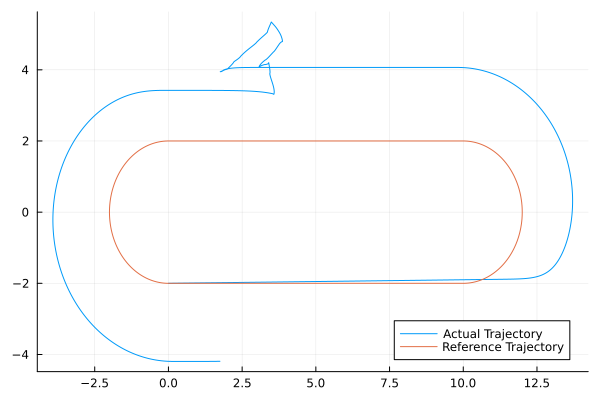

In [172]:
plot(traj_x_rect, traj_y_rect, label = "Actual Trajectory")
plot!(x_ref, y_ref, label = "Reference Trajectory")

As seen in the above graph, the heading angle is much greater than what the reference heading needs to be. The controller also supposedly turns slightly later than when it is supposed to. This might be a fundamental reason that resulted in its failure. The acceleration value might also be a reason that results in it overshooting its path. Getting the optimized acceleration value for a PID controller in Julia is difficult since other parameters are at play as well.

#### Circular Trajectory ####

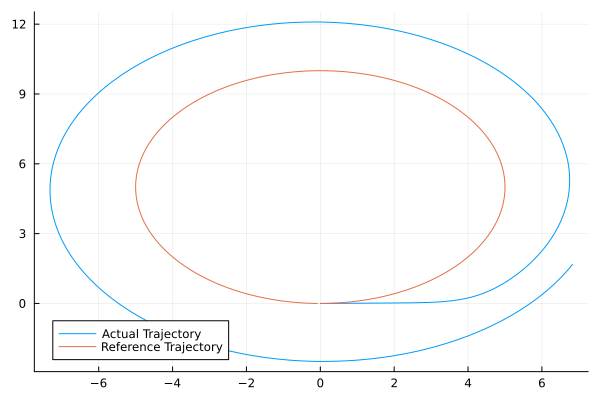

In [10]:
plot(traj_x_circle, traj_y_circle, label = "Actual Trajectory")
plot!(x_ref_circle, y_ref_circle, label = "Reference Trajectory")

The circular trajectory seems to fail for a similar reason mentioned above. Since the heading angle is not being calculated properly, the path calculated by the PID controller overshoots the original path and also forms a circle with a bigger radius for the same reasons.

#### Sinusoidal Trajectory ####

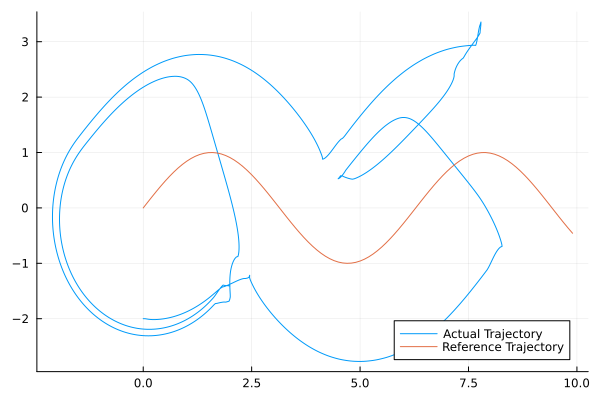

In [56]:
plot(traj_x_sin, traj_y_sin, label = "Actual Trajectory")
plot!(x_ref_sin, y_ref_sin, label = "Reference Trajectory")

The extremely bad behavior of the sine trajectory can be justified by the fact that the number of turns on this trajectory is much more than those seen in the previous two graphs. Also, the turns are in more than just one direction, therefore not having the right heading angle amplifies the bad performance on this trajectory.

### 4.2 MPC Controller Evaluation ###

#### Rectangular Trajectory ###

In [151]:
data = DataFrame(CSV.File("input_trajectory.csv"))
ref_traj = Matrix(data)
ref_x = ref_traj[:,1]
ref_y = ref_traj[:,2]

N = size(data)[1]
#ref_psi = ref_traj[:,3]
ref_v = ones(N)
ref_psi = zeros(N)
for i in 1:N-1
    ref_psi[i] = pi + atan(ref_y[i+1]-ref_y[i], ref_x[i+1]-ref_x[i])  
end
ref_traj = hcat(ref_traj,ref_psi,ref_v)
obstacles = []

#plot(ref_x,ref_y, label="refrence trajectory")

# obstacles = [ref_x[50] ref_y[50] 1]
# scatter!(obstacles[:,1], obstacles[:,2] ,label="obstacle")

Any[]

In [ ]:
T = 50
dt = 0.1
L = 0.1
Q = [10.0, 10.0, 1.0, 1.0]
R = [0.1, 0.1]
initial_state = [0.0, 0.0, 0, 1.0]
num_steps = N

state = initial_state
state_mat =  Matrix{Float64}(undef, num_steps,4)
control_mat =  Matrix{Float64}(undef, num_steps,2)
err_vec = []
delta_prev = 0
a_prev = 0
for step in 1:num_steps
    t = step * dt
    delta, a, err = mpc_solver(state, T, dt, L, Q, R, step, [delta_prev, a_prev], ref_traj, obstacles)
    state = bicycle_model(state, [delta, a], dt, L)
    state_mat[step,:] = state
    control_mat[step,:] = [delta, a]
    append!(err_vec, err)
    delta_prev = delta
    a_prev = a
    println("Step: ", step, ", State: ", state, ", Control Input: (", delta, ", ", a, ")")
    #break
end


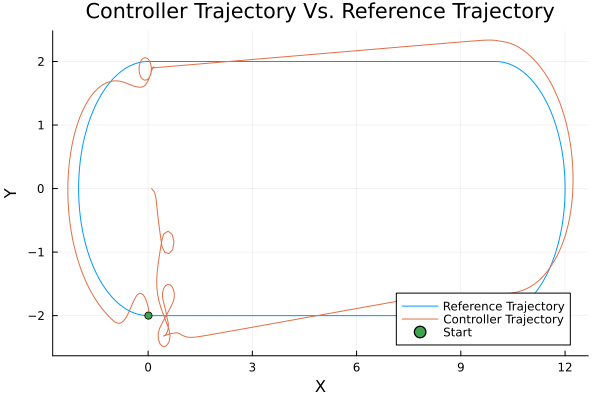

In [158]:
x = state_mat[:,1]
y = state_mat[:,2]
plot(ref_x[1:num_steps], ref_y[1:num_steps], label="Reference Trajectory", xguide = "X", yguide="Y", 
    title = "Controller Trajectory Vs. Reference Trajectory")
plot!(x,y, label="Controller Trajectory")
scatter!([ref_x[1]], [ref_y[1]],label="Start")

The MPC controller manages to stay on track for part of the refrence trajectory but looses control eventually. 

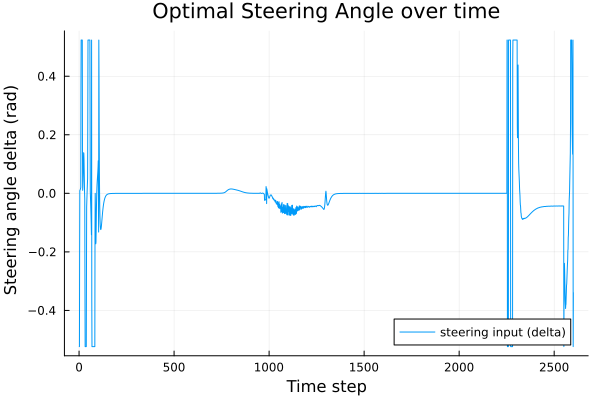

In [159]:
plot(1:num_steps, control_mat[:,1], 
    label="steering input (delta)", 
    xguide = "Time step",
    yguide = " Steering angle delta (rad)",
    title = "Optimal Steering Angle over time")

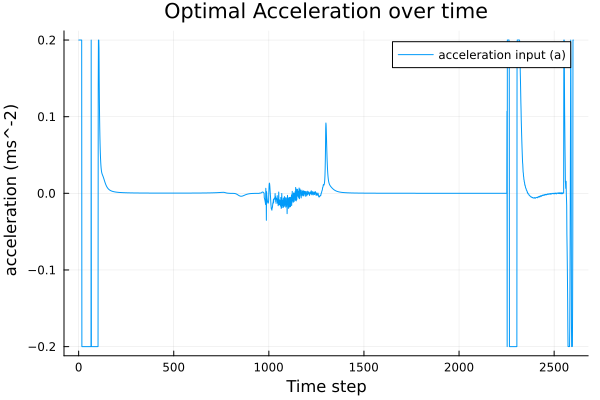

In [160]:
plot(1:num_steps, control_mat[:,2], label="acceleration input (a)",
    xguide = "Time step",
    yguide = " acceleration (ms^-2)",
    title = "Optimal Acceleration over time")

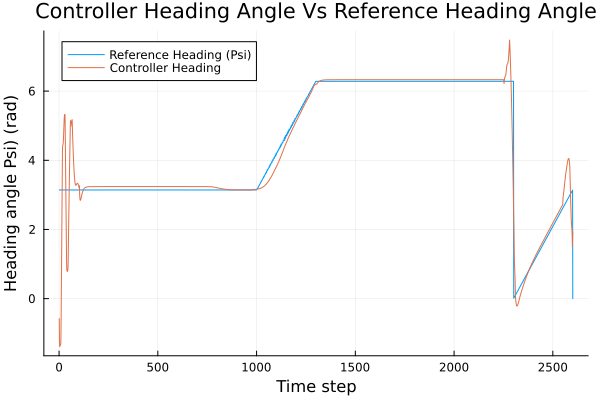

In [161]:
plot(1:num_steps, [ref_psi[1:num_steps],state_mat[:,3]], label=["Reference Heading (Psi)" "Controller Heading"],
xguide = "Time step",
yguide = "Heading angle Psi) (rad)",
title = "Controller Heading Angle Vs Reference Heading Angle")

The issue seems to be that the MPC controller is unable to match the heading angles at the begining (and end) of the track.

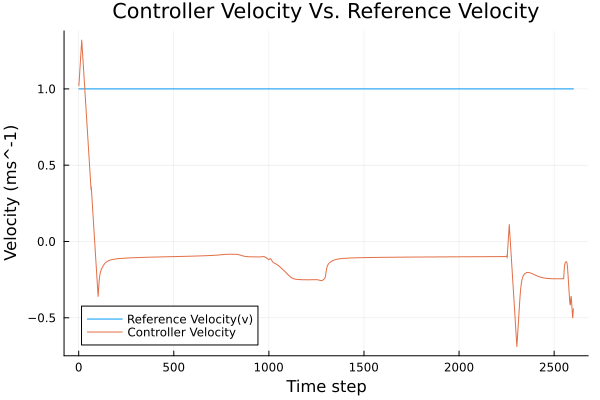

In [162]:
plot(1:num_steps, [ref_v[1:num_steps],state_mat[:,4]], label=["Reference Velocity(v)" "Controller Velocity"],
xguide = "Time step",
yguide = "Velocity (ms^-1)",
title = "Controller Velocity Vs. Reference Velocity")

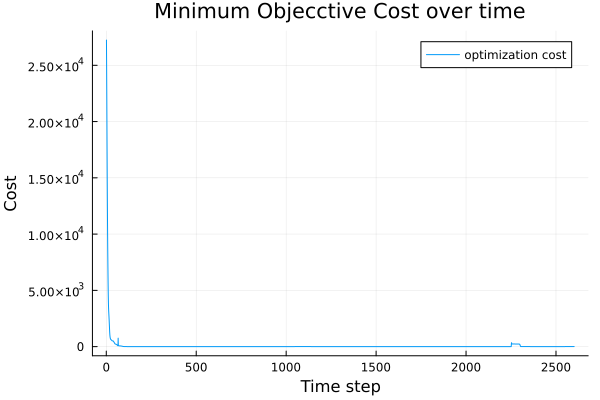

In [163]:
plot(1:num_steps, err_vec, label = "optimization cost", 
xguide =  "Time step",
yguide = "Cost",
title = "Minimum Objecctive Cost over time")

The mistakes the controller makes at the beginning cause a large error in the beginning but it comes down eventually. Overall, MPC messes up when it has to take turns, hence increasing the predicted horizon ($T$) in order to plan further ahead when doing optimization may lead to a better controller output.

#### Circular Trajectory ####

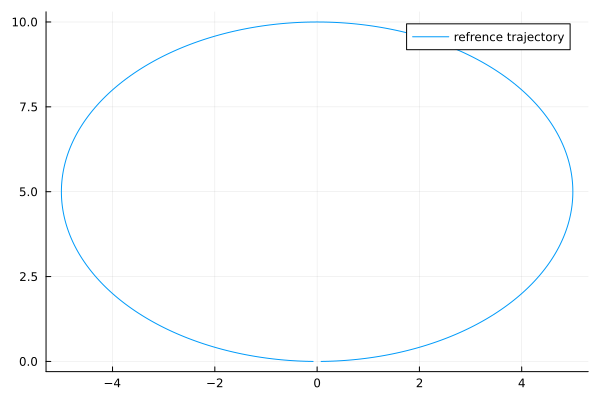

In [164]:
data = DataFrame(CSV.File("Circle_Traj_CW.csv"))
ref_traj = Matrix(data)
ref_x = ref_traj[:,1]
ref_y = ref_traj[:,2]
ref_psi = ref_traj[:,3]
ref_v = ref_traj[:,4]
N = size(data)[1]
obstacles = []
plot(ref_x,ref_y, label="refrence trajectory")

# obstacles = [ref_x[50] ref_y[50] 1]
# scatter!(obstacles[:,1], obstacles[:,2] ,label="obstacle")

In [ ]:
T = 50
dt = 0.1
L = 0.1
Q = [10.0, 10.0, 1.0, 1.0]
R = [0.1, 0.1]
initial_state = [0.0, 0.0, 0, 1.0]
num_steps = N

state = initial_state
state_mat =  Matrix{Float64}(undef, num_steps,4)
control_mat =  Matrix{Float64}(undef, num_steps,2)
err_vec = []
delta_prev = 0
a_prev = 0
for step in 1:num_steps
    t = step * dt
    delta, a, err = mpc_solver(state, T, dt, L, Q, R, step, [delta_prev, a_prev], ref_traj, obstacles)
    state = bicycle_model(state, [delta, a], dt, L)
    state_mat[step,:] = state
    control_mat[step,:] = [delta, a]
    append!(err_vec, err)
    delta_prev = delta
    a_prev = a
    println("Step: ", step, ", State: ", state, ", Control Input: (", delta, ", ", a, ")")
    #break
end


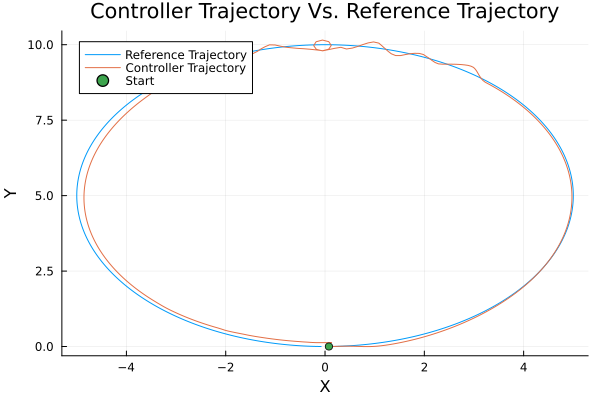

In [166]:
x = state_mat[:,1]
y = state_mat[:,2]
plot(ref_x[1:num_steps], ref_y[1:num_steps], label="Reference Trajectory", xguide = "X", yguide="Y", 
    title = "Controller Trajectory Vs. Reference Trajectory")
plot!(x,y, label="Controller Trajectory")
scatter!([ref_x[1]], [ref_y[1]],label="Start")

We can see that the MPC controller is able to keep to the actual reference path very well barring a few instances where it goes off track. We found that the instances where the MPC controller loops are when there is a greater error between the reference heading angle and the measured heading angle at places where the reference heading angle is close to 180 degrees.

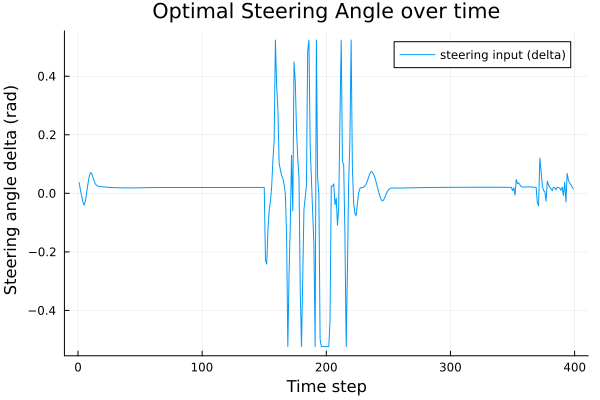

In [167]:
plot(1:num_steps, control_mat[:,1], 
    label="steering input (delta)", 
    xguide = "Time step",
    yguide = " Steering angle delta (rad)",
    title = "Optimal Steering Angle over time")

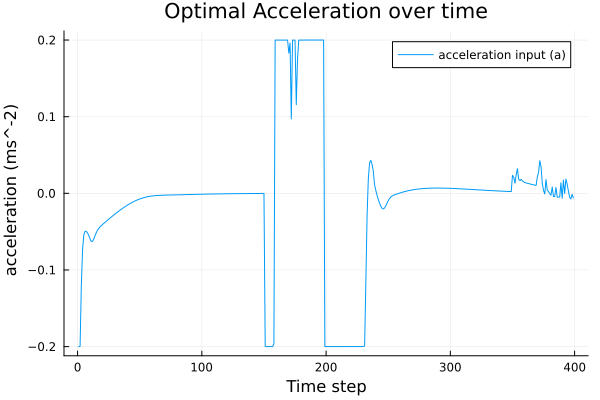

In [168]:
plot(1:num_steps, control_mat[:,2], label="acceleration input (a)",
    xguide = "Time step",
    yguide = " acceleration (ms^-2)",
    title = "Optimal Acceleration over time")

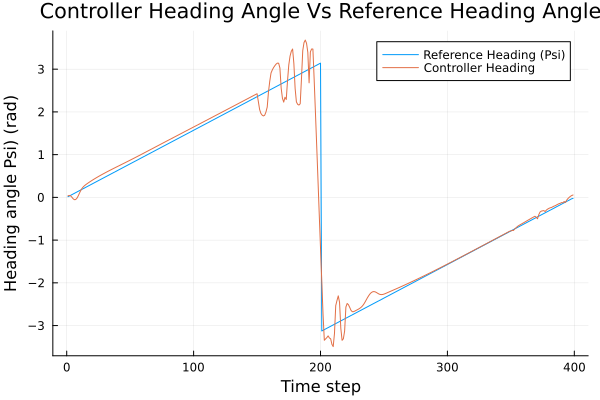

In [169]:
plot(1:num_steps, [ref_psi[1:num_steps],state_mat[:,3]], label=["Reference Heading (Psi)" "Controller Heading"],
xguide = "Time step",
yguide = "Heading angle Psi) (rad)",
title = "Controller Heading Angle Vs Reference Heading Angle")

As suspected, the controller heading angle is unable to match the reference heading angle at angles closer to 180 degrees.

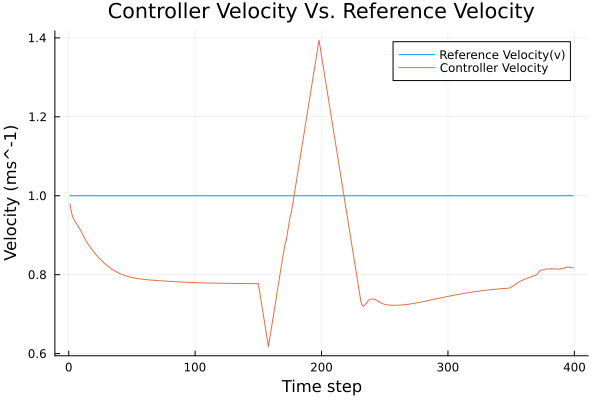

In [170]:
plot(1:num_steps, [ref_v[1:num_steps],state_mat[:,4]], label=["Reference Velocity(v)" "Controller Velocity"],
xguide = "Time step",
yguide = "Velocity (ms^-1)",
title = "Controller Velocity Vs. Reference Velocity")

MPC tries to keep the velocity closer to one, but it fails to always keep at a constant velocity. But, this is to be expected. There will always be some error in the control output. Although, one thing to note is that, the reference velocity was arbitrarily chosen to be one by the researchers who made the trajectory. There was not any prior motion planning done to create this trajectory, as such it may be physically difficult to always keep a constant velocity while on this track. Hence, some room for error is allowed and the error margin of the MPC controller is within acceptable limits.

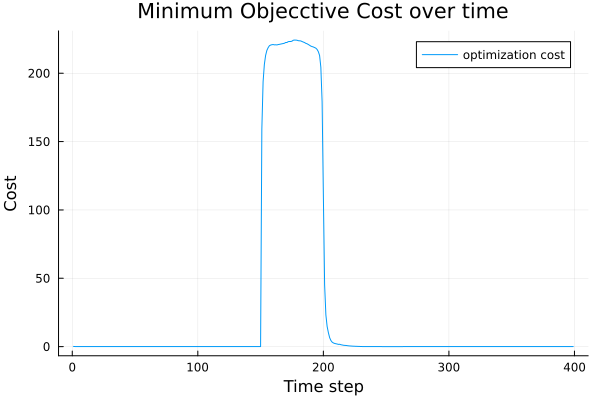

In [105]:
plot(1:num_steps, err_vec, label = "optimization cost", 
xguide =  "Time step",
yguide = "Cost",
title = "Minimum Objecctive Cost over time")

The value of the objective function is consistenly low, excpet for when the MPC controller veeers off track at extreme edge cases.

#### Sinusoidal Trajectory ####

In [132]:
# Create path
len = 200
t = range(0,step=0.1,length=len)
ref_traj = Matrix{Float64}(undef, len,4)
for (i,t) in enumerate(t)
    ref_traj[i,:] = sine_reference_trajectory_gen(t)
end
ref_x = ref_traj[:,1]
ref_y = ref_traj[:,2]
ref_psi = ref_traj[:,3]
ref_v = ref_traj[:,4]
N = len


obstacles = []

Any[]

In [ ]:
T = 50 # Predict horizon
dt = 0.1 # Time step
L = 0.1 # Length of bicycle model vehicle
Q = [10.0, 10.0, 1.0, 1.0] # Error penalty matrix
R = [0.1, 0.1] # Control penalty matrix
initial_state = [0.0, 0.0, 0, 1.0]
num_steps = 100

state = initial_state
state_mat =  Matrix{Float64}(undef, num_steps,4)
control_mat =  Matrix{Float64}(undef, num_steps,2)
err_vec = []
delta_prev = 0
a_prev = 0
for step in 1:num_steps
    t = step * dt
    delta, a, err = mpc_solver(state, T, dt, L, Q, R, step, [delta_prev, a_prev], ref_traj, obstacles)
    state = bicycle_model(state, [delta, a], dt, L)
    state_mat[step,:] = state
    control_mat[step,:] = [delta, a]
    append!(err_vec, err)
    delta_prev = delta
    a_prev = a
    println("Step: ", step, ", State: ", state, ", Control Input: (", delta, ", ", a, ")")
    #break
end


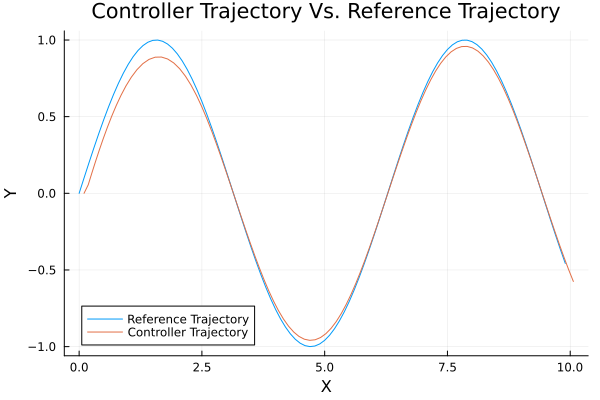

In [134]:
x = state_mat[:,1]
y = state_mat[:,2]
plot(ref_x[1:num_steps], ref_y[1:num_steps], label="Reference Trajectory", xguide = "X", yguide="Y", 
    title = "Controller Trajectory Vs. Reference Trajectory")
plot!(x,y, label="Controller Trajectory")
#scatter!(obstacles[:,1], obstacles[:,2],label="obstacle")

We see that the MPC controller keeps to the sinusoidal path quite accurately only veering off a bit at the peaks of the sine curve.

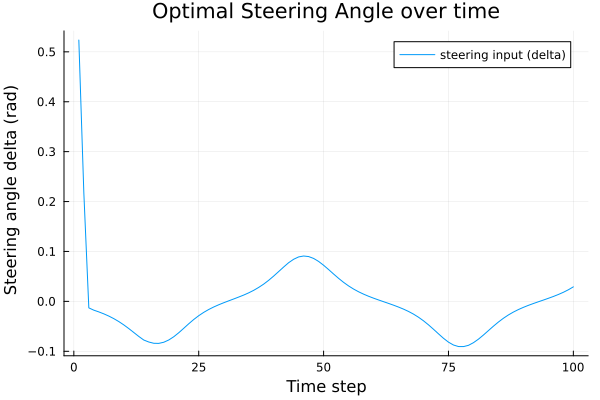

In [135]:
plot(1:num_steps, control_mat[:,1], 
    label="steering input (delta)", 
    xguide = "Time step",
    yguide = " Steering angle delta (rad)",
    title = "Optimal Steering Angle over time")

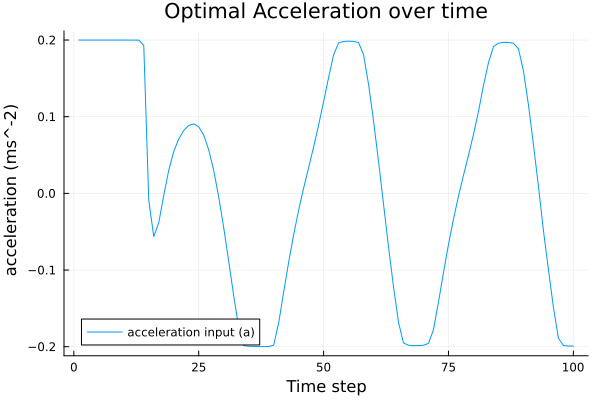

In [136]:
plot(1:num_steps, control_mat[:,2], label="acceleration input (a)",
    xguide = "Time step",
    yguide = " acceleration (ms^-2)",
    title = "Optimal Acceleration over time")

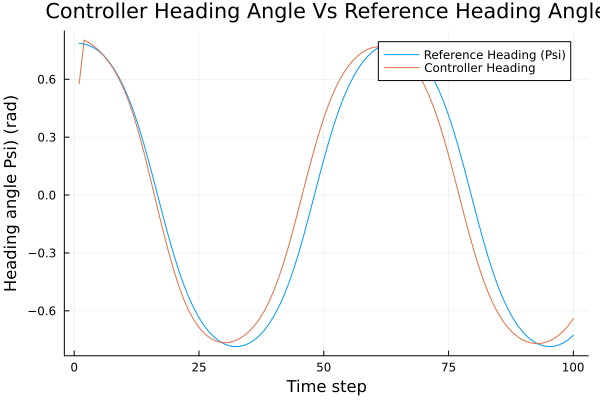

In [137]:
plot(1:num_steps, [ref_psi[1:num_steps],state_mat[:,3]], label=["Reference Heading (Psi)" "Controller Heading"],
xguide = "Time step",
yguide = "Heading angle Psi) (rad)",
title = "Controller Heading Angle Vs Reference Heading Angle")

MPC controller also mananges to match the heading angle rather accurately as well.

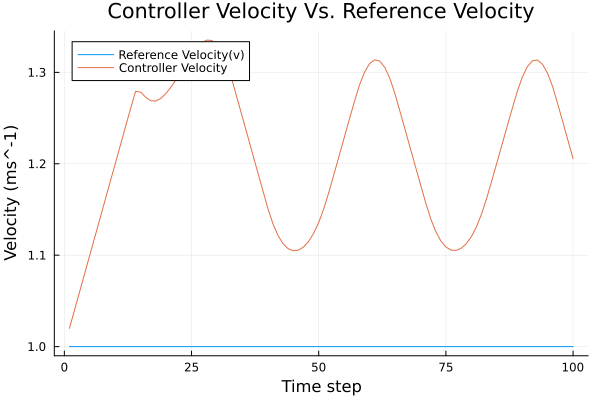

In [138]:
plot(1:num_steps, [ref_v[1:num_steps],state_mat[:,4]], label=["Reference Velocity(v)" "Controller Velocity"],
xguide = "Time step",
yguide = "Velocity (ms^-1)",
title = "Controller Velocity Vs. Reference Velocity")

As with othe trajectories MPC is not always able to stay at constant velocity, but stays within an acceptable margin of error.

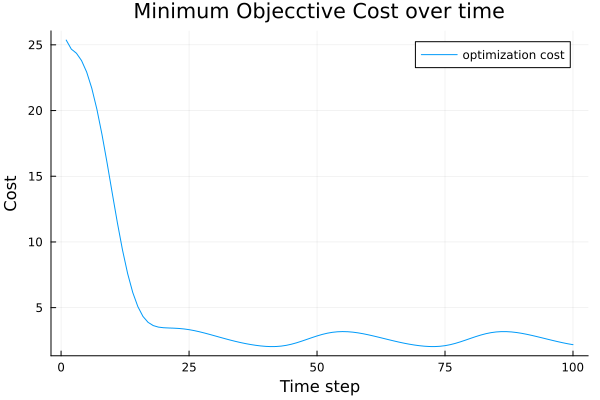

In [139]:
plot(1:num_steps, err_vec, label = "optimization cost", 
xguide =  "Time step",
yguide = "Cost",
title = "Minimum Objecctive Cost over time")

The error of the optimizations have a lower range compared to other trajectories, that is MPC performed best on the Sinusoidal track.

#### Sinusoidal Trajectory with Obstacles ####

In this scenario, we test the MPC controller on a sinusoidal trajectory with two obstacles on it. For simplicity, we assume the obstacles are circular and have a radius of $0.2$m. The MPC controller must try to stay on the path while also avoiding the obstacles.

In [140]:
len = 200
t = range(0,step=0.1,length=len)
ref_traj = Matrix{Float64}(undef, len,4)
for (i,t) in enumerate(t)
    ref_traj[i,:] = sine_reference_trajectory_gen(t)
end
ref_x = ref_traj[:,1]
ref_y = ref_traj[:,2]
ref_psi = ref_traj[:,3]
ref_v = ref_traj[:,4]
N = len
obstacles = []

obstacles = [ref_x[50] ref_y[50] 0.2;
             ref_x[20] ref_y[20] 0.2]

2×3 Matrix{Float64}:
 4.9  -0.982453  0.2
 1.9   0.9463    0.2

In [ ]:
T = 50
dt = 0.1
L = 0.1
Q = [10.0, 10.0, 1.0, 1.0]
R = [0.1, 0.1]
initial_state = [0.0, 0.0, 0, 1.0]
num_steps = 100

state = initial_state
state_mat =  Matrix{Float64}(undef, num_steps,4)
control_mat =  Matrix{Float64}(undef, num_steps,2)
err_vec = []
delta_prev = 0
a_prev = 0
for step in 1:num_steps
    t = step * dt
    delta, a, err = mpc_solver(state, T, dt, L, Q, R, step, [delta_prev, a_prev], ref_traj, obstacles)
    state = bicycle_model(state, [delta, a], dt, L)
    state_mat[step,:] = state
    control_mat[step,:] = [delta, a]
    append!(err_vec, err)
    delta_prev = delta
    a_prev = a
    println("Step: ", step, ", State: ", state, ", Control Input: (", delta, ", ", a, ")")
    #break
end


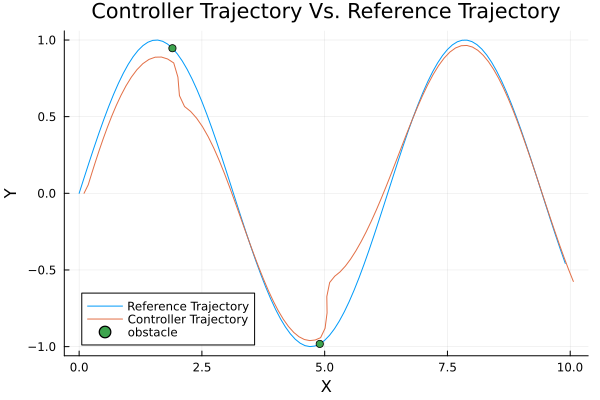

In [143]:
x = state_mat[:,1]
y = state_mat[:,2]
plot(ref_x[1:num_steps], ref_y[1:num_steps], label="Reference Trajectory", xguide = "X", yguide="Y", 
    title = "Controller Trajectory Vs. Reference Trajectory")
plot!(x,y, label="Controller Trajectory")
scatter!(obstacles[:,1], obstacles[:,2],label="obstacle")

The MPC controller successfully avoids both obstacles while taking the least costly path off-track to do so.

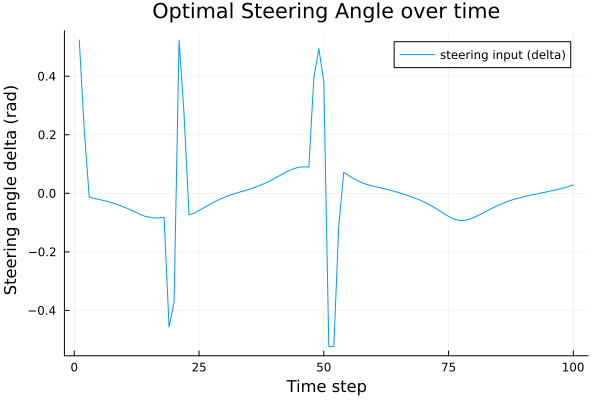

In [144]:
plot(1:num_steps, control_mat[:,1], 
    label="steering input (delta)", 
    xguide = "Time step",
    yguide = " Steering angle delta (rad)",
    title = "Optimal Steering Angle over time")

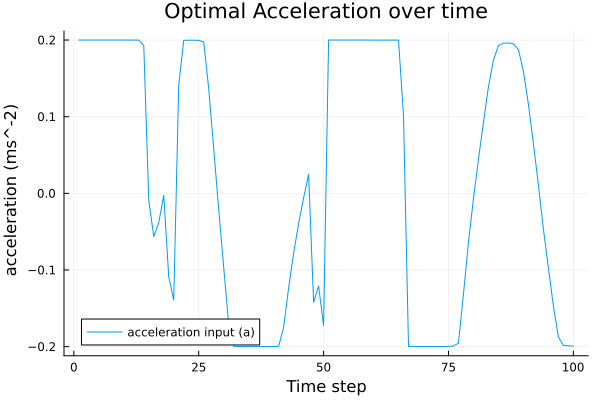

In [145]:
plot(1:num_steps, control_mat[:,2], label="acceleration input (a)",
    xguide = "Time step",
    yguide = " acceleration (ms^-2)",
    title = "Optimal Acceleration over time")

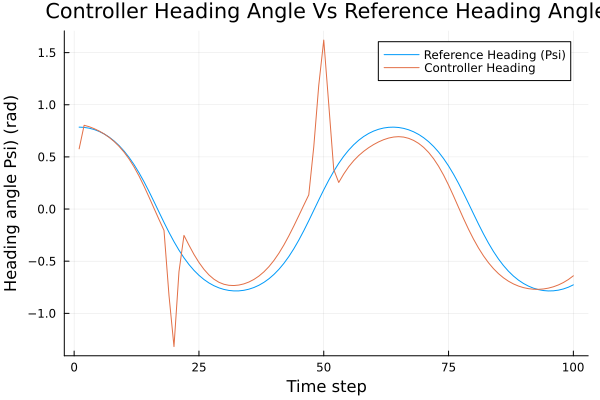

In [146]:
plot(1:num_steps, [ref_psi[1:num_steps],state_mat[:,3]], label=["Reference Heading (Psi)" "Controller Heading"],
xguide = "Time step",
yguide = "Heading angle Psi) (rad)",
title = "Controller Heading Angle Vs Reference Heading Angle")

The MPC controllers manage to match the heading angle well, except for in instances where the vehicle has to move off track to avoid obstacles.

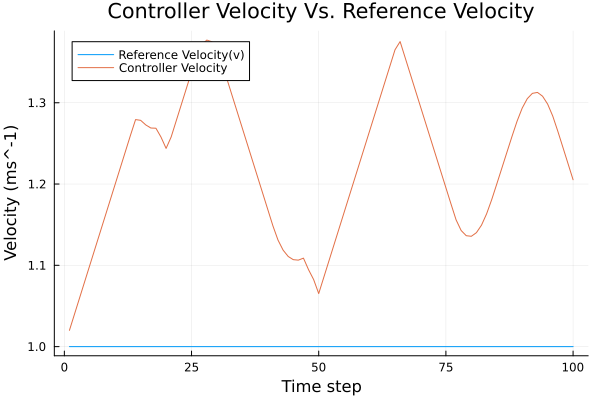

In [147]:
plot(1:num_steps, [ref_v[1:num_steps],state_mat[:,4]], label=["Reference Velocity(v)" "Controller Velocity"],
xguide = "Time step",
yguide = "Velocity (ms^-1)",
title = "Controller Velocity Vs. Reference Velocity")

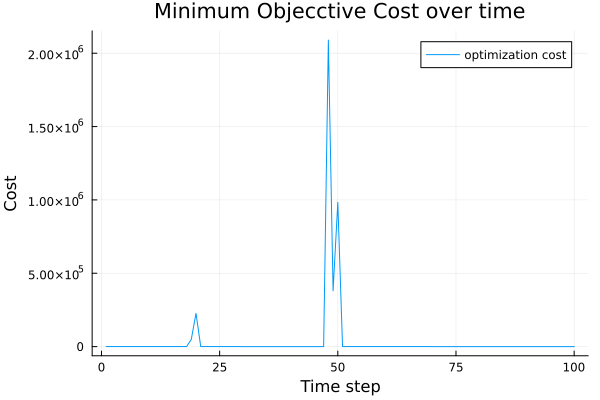

In [148]:
plot(1:num_steps, err_vec, label = "optimization cost", 
xguide =  "Time step",
yguide = "Cost",
title = "Minimum Objecctive Cost over time")

The overall cost of the controller trajectory stays low most of the time, except for when the controller has to go off track to avoid obstacles.

## 5. Conclusion ##

#### PID Controller #### 
- The PID controller, unfortunately, fails to keep to the reference trajectory in all of the test trajectories. 
- PID controllers require the proper tuning of the gain coefficients in order to function properly. Hence, one future direction may be to develop a pipeline to find the optimal gain coefficients.


#### MPC Controller ### 

-  MPC performs significantly better than PID control and manages to perform well on all of the trajectories.
- However, in circular trajectories, MPC controllers struggle to find a proper path at extreme heading angles (like 180 degrees) and veer off track for a bit.
- This issue can be mitigated by defining specific behavior for an MPC controller at extreme angles.
- The MPC controller has low sensitivity to its tuning parameters as all the above control trajectories were calculated using the same set of parameters except for the number of steps (as it is trajectory dependent)
- The MPC controller is also able to successfully avoid static obstacles in the path.
- However, making it avoid dynamic obstacles is rather difficult, as we need to model the dynamics of those objects as well. Furthermore, we need to understand that those dynamic objects plan like us as well making the problem even more difficult. Hence, a future direction of research would be to look into developing an MPC controller that is able to respond to dynamic obstacles.

Moving forward, we plan on using an MPC-based control policy in our autonomous control stack for the competition. MPC control proved itself to be a robust optimal control algorithm. However, the only downside is the increased computational cost due to having to solve an optimization problem at each time step. But, this can be avoided by having a powerful computing platform.